<a href="https://colab.research.google.com/github/arqavan94/Conv1D-BiGRU/blob/main/CNN_BiGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import math
import pickle as pkl
from sklearn.preprocessing import MinMaxScaler
import requests
import tensorflow as tf
from datetime import datetime
from keras.models import load_model
from tensorflow.keras.callbacks import  EarlyStopping
from tensorflow import keras
from keras.layers import Dense, Bidirectional , Flatten,Conv1D,MaxPooling1D, TimeDistributed
from timeit import default_timer as timer
import time
import matplotlib.pyplot as plt
from numpy import nan
from numpy import array
from keras.layers import Input, concatenate, Dense, Concatenate, Dropout,GRU
from keras.models import Model
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU
import pickle
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import shuffle
import time
from tensorflow.keras import initializers

In [ ]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

**Create data with time_step= 10 day-ahead and step_size = 24 next hour**

In [ ]:
def create_dataset(X, y, time_steps=1,step_size=1):
    Xs, ys = [], []
    for i in range(len(X) - (time_steps + step_size)):
        v = X.iloc[i:(i + time_steps),0:].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps:(i + time_steps)+step_size].values)
    Xs = np.asarray(Xs).astype('float32')
    ys = np.asarray(ys).astype('float32')

    return Xs, ys,

In [ ]:
def split_data(df):
  train_size = int(np.floor(len(df) * 0.95))
  test_size = len(df) - train_size
  train, test = df[0:train_size], df[train_size:len(df)]
  return train, test

**Scale Data with MinMaxScaler**

In [ ]:
def scale(train, test):

  f_columns= ['temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'day', 'hour', 'month',
       'year', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday', 'winter', 'spring', 'summer', 'fall', 'working_day']
  f_transformer = MinMaxScaler(feature_range=(0,1))
  f_transformer = f_transformer.fit(train[f_columns].to_numpy())
  train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
  test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())

  cnt_transformer = MinMaxScaler(feature_range=(0,1))
  cnt_transformer = cnt_transformer.fit(train[['AP']])
  train['AP'] = cnt_transformer.transform(train[['AP']])
  test['AP'] = cnt_transformer.transform(test[['AP']])
  return f_transformer,cnt_transformer, train, test

In [ ]:
def inverse_transform(series,scaler):
    return scaler.inverse_transform(series)

**Load Data**

In [ ]:
train= pd.read_csv('/content/drive/MyDrive/masterthesis_data/city_v2.csv',index_col='date')
test= pd.read_csv('/content/drive/MyDrive/masterthesis_data/city_small_v2.csv',index_col='date')
dataframe= pd.concat([train, test],ignore_index=False, sort=False)
dataframe['public_holiday']= dataframe['public_holiday'].astype(int)
dataframe['usual_holidays']= dataframe['usual_holidays'].astype(int)
dataframe['hijri_holiday']= dataframe['hijri_holiday'].astype(int)
dataframe.drop(columns=['hijri_holiday','public_holiday','usual_holidays'], inplace=True)
dataframe

,AP,temp,dwpt,rhum,wdir,wspd,day,hour,month,year,...,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,winter,spring,summer,fall
date,,,,,,,,,,,,,,,,,,,,,
2017-03-21 00:00:00,384.03372,14.3,6.6,60.0,160.0,0.0,21,0,3,2017,...,0,0,1,0,0,0,0.0,1.0,0.0,0.0
2017-03-21 01:00:00,346.36252,13.0,7.0,67.0,160.0,11.2,21,1,3,2017,...,0,0,1,0,0,0,0.0,1.0,0.0,0.0
2017-03-21 02:00:00,314.41953,15.0,4.1,48.0,220.0,25.9,21,2,3,2017,...,0,0,1,0,0,0,0.0,1.0,0.0,0.0
2017-03-21 03:00:00,293.23193,14.9,2.7,44.0,250.0,7.2,21,3,3,2017,...,0,0,1,0,0,0,0.0,1.0,0.0,0.0
2017-03-21 04:00:00,283.35095,16.0,3.1,42.0,350.0,14.8,21,4,3,2017,...,0,0,1,0,0,0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-15 19:00:00,1414.19130,29.0,15.2,43.0,140.0,7.0,15,19,6,2022,...,1,0,0,0,0,0,0.0,0.0,1.0,0.0
2022-06-15 20:00:00,1469.92430,27.0,15.1,48.0,210.0,11.0,15,20,6,2022,...,1,0,0,0,0,0,0.0,0.0,1.0,0.0
2022-06-15 21:00:00,1471.81800,26.0,15.1,51.0,210.0,7.0,15,21,6,2022,...,1,0,0,0,0,0,0.0,0.0,1.0,0.0


**Add working_days to dataset**

In [ ]:
def add_workingday(dataframe):
  dataframe.index= pd.to_datetime(dataframe.index)
  dayOfWeek={2:'Monday', 3:'Tuesday', 4:'Wednesday', 5:'Thursday', 6:'Friday', 0:'Saturday',1:'Sunday'}
  dataframe['day_of_week'] = dataframe.index.day_of_week.map(dayOfWeek)
  dataframe.loc[dataframe['day_of_week'].isin(['Thursday', 'Friday']), 'working_day'] = 0
  dataframe.loc[dataframe['day_of_week'].isin(['Monday', 'Tuesday','Wednesday','Saturday','Sunday']), 'working_day'] = 1
  dataframe.drop(columns=['day_of_week'], inplace=True)
  return dataframe
dataframe= add_workingday(dataframe)


**Outlier_detection**

In [ ]:
Q1 = dataframe['AP'].quantile(0.25)
Q3 = dataframe['AP'].quantile(0.75)
IQR = Q3 - Q1

df2 = dataframe[((dataframe['AP'] < (Q1 - 2 * IQR)) |(dataframe['AP'] > (Q3 + 2 * IQR)))]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f020982c7c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f020982cd00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f02097df370>],
 'medians': [<matplotlib.lines.Line2D at 0x7f020982d240>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f020982d780>],
 'means': [<matplotlib.lines.Line2D at 0x7f020982d4e0>]}

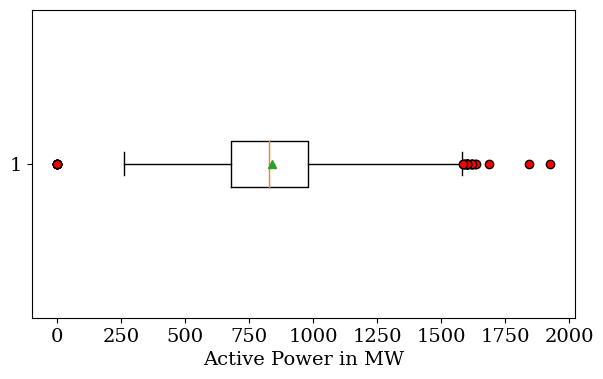

In [ ]:
red_square = dict(markerfacecolor='r', marker='o')
# plt.figure(figsize=(7,5))
fig1, ax1 = plt.subplots(figsize=(7,4))
# plt.set_title('IQR Method')
plt.xlabel('Active Power in MW',size=14)
ax1.tick_params(axis='both', labelsize=14)
plt.boxplot(dataframe['AP'], flierprops=red_square, vert=False, whis=2, showmeans=True)
# plt.savefig("boxplot.png")

Text(0, 0.5, 'Active Power in MW')

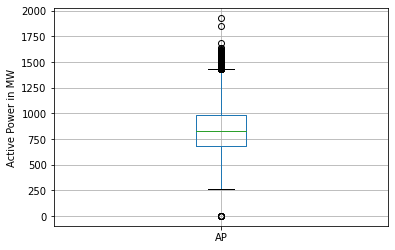

In [ ]:
dataframe.boxplot(column=['AP'], return_type='axes')
plt.ylabel('Active Power in MW')

In [ ]:
for index in df2.index:
  if (str(index) =='2019-09-21 23:00:00' or str(index) =='2021-09-21 23:00:00'):
     dataframe.loc[index,'AP']= np.nan
dataframe['AP']= dataframe['AP'].replace(0,np.nan)

dataframe['AP'].fillna(dataframe.AP.rolling(window=7,min_periods=1).mean(),inplace=True)

Text(0, 0.5, 'Active Power in MW')

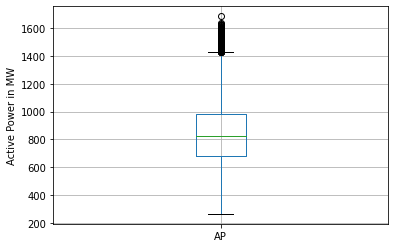

In [ ]:
dataframe.boxplot(column=['AP'], return_type='axes')
plt.ylabel('Active Power in MW')

**Train Model**

In [ ]:
def Uncompiled_CNN_GRU(X_train, horizon):

  # Conv1D
  visible1 = Input(shape=(X_train.shape[1], X_train.shape[2]))

  pool11 = Conv1D(64, activation='relu', kernel_size=2, strides=1,kernel_initializer=initializers.RandomNormal(stddev=0.01))(visible1)
  pool11 = Conv1D(64, activation='relu', kernel_size=2, strides=1,kernel_initializer=initializers.RandomNormal(stddev=0.01))(pool11)
  pool11 = MaxPooling1D(strides=2)(pool11)

  # Conv1D
  visible2 = Input(shape=(X_train.shape[1], X_train.shape[2]))
  pool21 = Conv1D(64, activation='relu',  kernel_size=2,strides=1,kernel_initializer=initializers.RandomNormal(stddev=0.01))(visible2)
  pool21 = Conv1D(64, activation='relu',  kernel_size=2,strides=1,kernel_initializer=initializers.RandomNormal(stddev=0.01))(pool21)
  pool21 = MaxPooling1D(strides=2)(pool21)

  GRU1 = Bidirectional(CuDNNGRU(100, name='GRU1', return_sequences=False))(pool11)
  GRU2 = Bidirectional(CuDNNGRU(100, name='GRU2', return_sequences=False))(pool21)

  concat = concatenate([GRU1, GRU2])

  concat =  Dropout(0.1)(concat)
  output = Dense(horizon, activation='relu')(concat)
  model = Model(inputs=[visible1, visible2], outputs=output)
  model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mae','mape'])
  model.summary()
  return model

# **Evaluation**

In [ ]:
def evaluate(y_test,y_pred):

  RMSE= sqrt(mean_squared_error(y_test, y_pred))
  MAE= mean_absolute_error(y_test, y_pred)
  MAPE = np.mean(np.abs((y_test - y_pred)/y_test))*100
  r2 = r2_score(y_test, y_pred)
  return RMSE, MAE ,MAPE, r2

# **Predction**

In [ ]:
def run_multi_input_multi_output(X_train, y_train, horizon):


    model = Uncompiled_CNN_GRU(X_train, horizon)
    start_time = time.time()
    history= model.fit(x=[X_train, X_train] , y=y_train, batch_size=128, epochs=100,validation_split=0.2,
                       callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.2f} seconds")
    return model, y_scaler, history

In [ ]:
time_step= 10*24
step_size= 24
horizon= 24
train, test= split_data(dataframe)
x_scaler, y_scaler, train, test= scale(train, test)
X_train, y_train= create_dataset(train,train.AP, time_step, step_size)
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = create_dataset(test, test.AP, time_step, step_size)
X_test, y_test = shuffle(X_test, y_test)

<ipython-input-6-5ebf6d0ad944>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
<ipython-input-6-5ebf6d0ad944>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
<ipython-input-6-5ebf6d0ad944>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [ ]:
def ViewLoss(history):
    '''
    Plots the history of model training
    '''
    # plt.figure(figsize=(3.48761,2.5))
    plt.plot(history.history['loss'],label='Train')
    plt.plot(history.history['val_loss'],label='Validation')
    plt.ylabel('Training and Validation Loss',size=14)
    plt.xlabel('Epoch')
    plt.legend(['Loss', 'Validation_Loss'], loc='upper center')
    plt.tight_layout()
    plt.show()
    # plt.savefig(f'val_loss.png')

In [ ]:
model, y_scaler, history= run_multi_input_multi_output(X_train, y_train, horizon)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 22)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 240, 22)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 239, 64)      2880        ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 239, 64)      2880        ['input_2[0][0]']                
                                                                                              

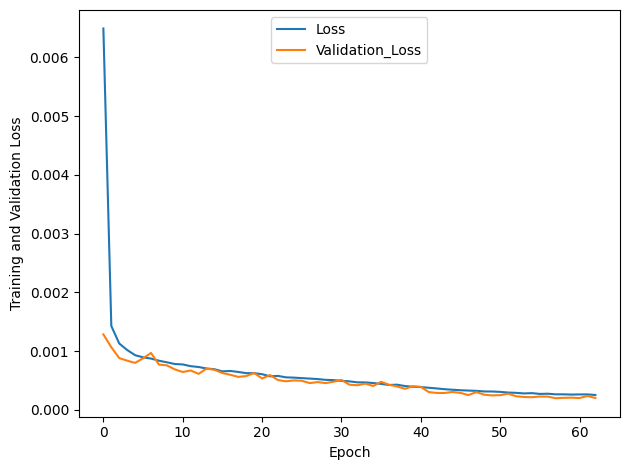

In [ ]:
ViewLoss (history)

In [ ]:
# Make predictions
test_X_pred = np.copy(X_test)
y_pred = []
for i in range(len(X_test)):
    test_X_step = np.expand_dims(test_X_pred[i], axis=0)
    y_step = model.predict([test_X_step , test_X_step])[0]
    y_step = y_step.reshape((1, step_size, 1))
    # print(y_step)
    y_pred.append(y_step)
    # print(y_step.reshape((step_size, 1)))
    test_X_pred[i, -step_size:, :] =  y_step.reshape((step_size, 1))

y_pred = np.array(y_pred)

# Rescale data
y_test_rescaled = y_scaler.inverse_transform(y_test.reshape(-1, step_size))
y_pred_rescaled = y_scaler.inverse_transform(y_pred.reshape(-1, step_size))

# with open("/content/drive/MyDrive/prediction_diagrams/our_model.pkl", "wb") as f:
#     pkl.dump(y_pred_rescaled,f)

# Evaluation
RMSE, MAE , MAPE, r2= evaluate(y_test_rescaled,y_pred_rescaled)
print('MAE for hybrid model is {}'.format(MAE))
print('RMSE for hybrid model is {}'.format(RMSE))
print('MAPE for hybrid model is {}'.format(MAPE))
print('R^2 for hybrid model is {}'.format(r2))

1/1 [==============================] - 0s 36ms/step
MAE for hybrid model is 37.366336822509766
RMSE for hybrid model is 56.87161090520581
MAPE for hybrid model is 4.1670214384794235
R^2 for hybrid model is 0.8982699893161122


In [ ]:
y_test_rescaled.shape

(2008, 48)

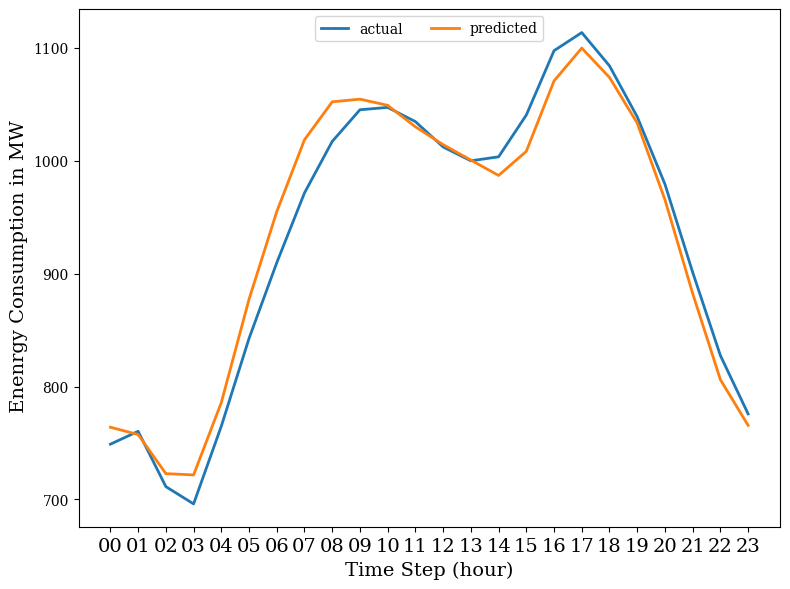

In [ ]:
x_axis = pd.date_range(start="2017-1-1",periods=24, freq="1h").strftime("%H")
plt.figure(figsize=(8,6))
plt.plot(y_test_rescaled[52], marker=',',label='true',linewidth=2)
plt.plot(y_pred_rescaled[52], marker=',',label='Predicted',linewidth=2)
plt.xticks(np.arange(0, len(x_axis), 1), x_axis[::1], size=14)
plt.xlabel('Time Step (hour)', size=14)
plt.ylabel(' Enenrgy Consumption in MW', size=14)
plt.legend(['actual', 'predicted'], loc='upper center', ncol=2)
plt.tight_layout()
fig1 = plt.gcf()
# fig1.savefig(f'/content/drive/MyDrive/.png', dpi=100)
plt.show()

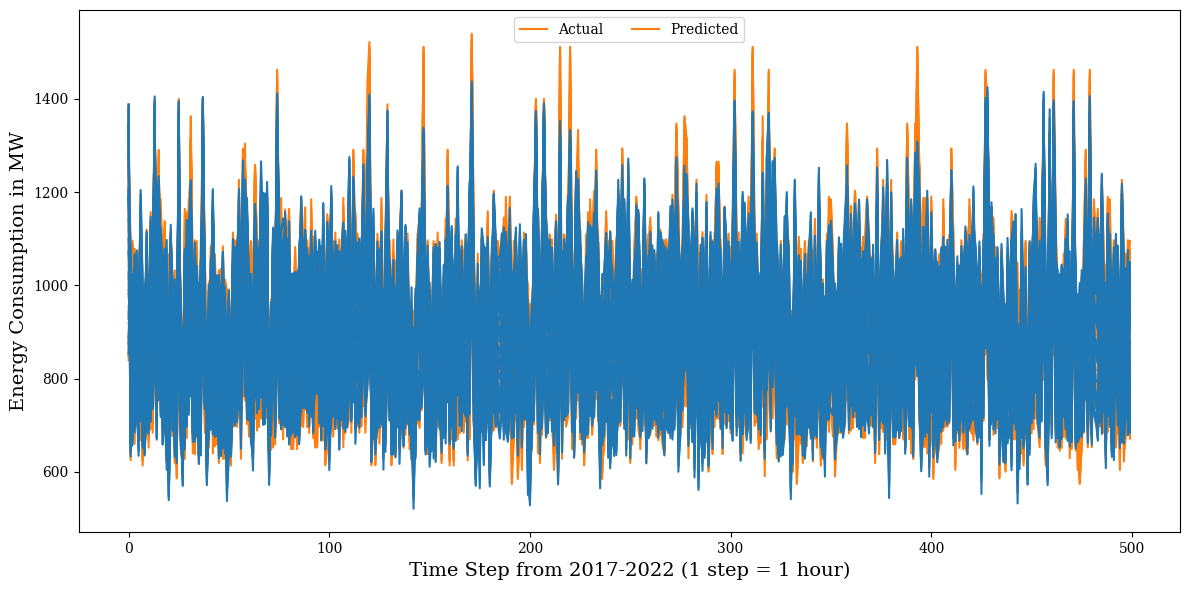

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(y_test_rescaled[0:500], color='tab:orange')
ax1.plot(y_pred_rescaled[0:500], color='tab:blue')

ax1.legend(['Actual', 'Predicted'], loc='upper center', ncol=2)
ax1.set_ylabel('Energy Consumption in MW', size=14)
ax1.set_xlabel('Time Step from 2017-2022 (1 step = 1 hour)', color='black', size=14)

fig.tight_layout()
plt.savefig('output.png')
plt.show()